# MLFlow

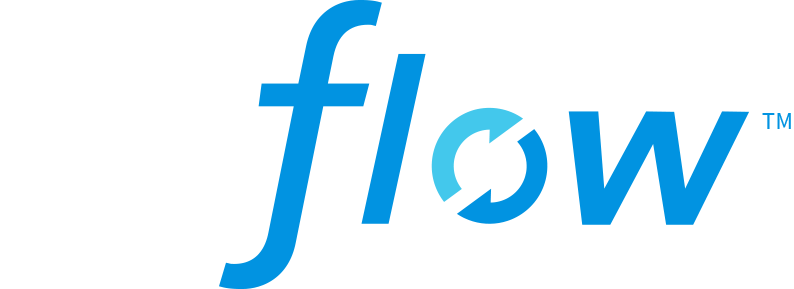

## Назначение

- Отслеживание экспериментов
- Упаковка кода в воспроизводимый формат
- Хранение, управление и разворачивание моделей

### Из чего состоит MLflow

- MLflow Tracking
- MLflow Projects
- MLflow Models

### Что еще бывает?

- Databricks (MLflow + MLflow Registry)
- Kubeflow
- DVC
- TensorBoard
- ClearML
- Neptune

## MLflow Tracking

**MLflow Tracking** -  это набор из API и UI для логирования параметров, версий кода, метрик и выходных файлов для ваших моделей машинного обучения, а также для визуализации результатов

In [ ]:
import mlflow

### Давайте что-нибудь залогируем!

### MLflow UI запускается командой `mlflow ui`

**MLflow Tracking** крутится вокруг концепции *runs*, единиц исполнения элементов работы дата саентиста. Каждый run состот из:
* Code Version
* Start & End Time
* Source
* Parameters
* Metrics
* Artifacts

### *Run* запускается автоматические, как только мы что-то начали логировать

### Требутся явно завершить исполнение run для запуска следующего

### Несколько экземпляторов run могу быть собраны в объект *experiment*

In [ ]:
experiment_id = mlflow.create_experiment("My first experiment")

In [ ]:
experiment_id

In [ ]:
with mlflow.start_run(experiment_id=experiment_id):
    mlflow.log_param("param", "param-pam-pam")

### Если явно не задать нахзвание эксперимента, все упадет в "Default"

In [ ]:
with mlflow.start_run():
    mlflow.log_metric("PR AUC", 1)

### Run тоже можно поименовать

In [ ]:
with mlflow.start_run(experiment_id=experiment_id, run_name="Run with default hyperparameters"):
    mlflow.log_param("alpha", 0.01)
    mlflow.log_metric("PR AUC", 1)

### С сервером MLflow можно взаимодействовать через объект `MlflowClient`

In [ ]:
client = mlflow.tracking.MlflowClient()

In [ ]:
client

In [ ]:
experiment = client.get_experiment_by_name("My first experiment")

In [ ]:
experiment

In [ ]:
client.search_runs(experiment_ids=experiment.experiment_id, filter_string="metrics.`PR AUC` > 0.9")

### [Больше про поиск](https://www.mlflow.org/docs/latest/search-runs.html)

### MLflow tracking server состоит из двух компонентов:
* backend store
* artifact store

Компонент **backend store**  - это хранилище экспериментов и метаданных для запусков вместе с тегами, параметрами и метриками.  
Данные хранятся в файловом видел или в совместимом с SQLAlchemy хранилище.  
По умолчанию хранилище файловое.

In [ ]:
EXPERIMENT_ID = "0"

In [ ]:
!ls mlruns

In [ ]:
RUN_ID = client.search_runs(experiment_ids=EXPERIMENT_ID)[-1].info.run_id

In [ ]:
RUN_ID

In [ ]:
!ls mlruns/$EXPERIMENT_ID/$RUN_ID/metrics/

### Компоненет artifact store обычно требует подходящего для хранения больших бинарных файлов хранилища (файловая система, hdfs, s3), куда клиент сложит свои артефакты.

In [ ]:
!ls mlruns/$EXPERIMENT_ID/$RUN_ID/artifacts

In [ ]:
!cat mlruns/$EXPERIMENT_ID/$RUN_ID/meta.yaml

### artifact store полезен для передачи модели вместе с датасетом, чтобы не приходилось все собирать с нуля

## MLflow models
### MLflow Model использует стандарный формат для упаковки моделей, чтобы его можно было просто встроить в любой программный продукт - от апишки до Spark.

In [ ]:
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [ ]:
X, y = make_classification()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(*make_classification())

In [ ]:
estimator = RandomForestClassifier()
estimator.fit(X_train, y_train)

In [ ]:
estimator.score(X_test, y_test)

In [ ]:
import mlflow.sklearn

In [ ]:
with mlflow.start_run():
    mlflow.sklearn.log_model(estimator, artifact_path="models")

In [ ]:
mlflow.end_run()

### `log_model` сохраняет модель, но не отслеживает гиперпараметры. Как быть?

In [ ]:
mlflow.end_run()

In [ ]:
with mlflow.start_run():
    estimator = RandomForestClassifier()
    mlflow.log_params(estimator.get_params())
    estimator.fit(X_train, y_train)
    accuracy = estimator.score(X_test, y_test)
    mlflow.log_metric("Accuracy", accuracy)
    mlflow.sklearn.log_model(estimator, artifact_path="models")

### Некоторые имплементации моделей поддерживают [automatic logging](https://www.mlflow.org/docs/latest/tracking/tracking-api.html#id1)

In [ ]:
import xgboost
import mlflow.xgboost

In [ ]:
param = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic'}
num_round = 3

In [ ]:
mlflow.xgboost.autolog()

In [ ]:
dtrain = xgboost.DMatrix(data=X_train, label=y_train)

In [ ]:
dtest = xgboost.DMatrix(data=X_test, label=y_test)

In [ ]:
with mlflow.start_run():
    bst = xgboost.train(param, dtrain, num_round)

In [ ]:
estimator = RandomForestClassifier()

In [ ]:
mlflow.sklearn.autolog()

In [ ]:
with mlflow.start_run():
    estimator.fit(X_train, y_train)

### Модель можно даже скормить Spark UDF.

In [ ]:
from sklearn.datasets import load_iris
import pandas as pd

In [ ]:
data = load_iris(as_frame=True)

In [ ]:
pdf = data["frame"]
target = pdf.pop("target")

In [ ]:
pdf.head()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [ ]:
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression())
])

In [ ]:
pdf_train, pdf_test, target_train, target_test = train_test_split(pdf, target)

In [ ]:
experiment_id = mlflow.set_experiment("Iris with sklearn")

In [ ]:
with mlflow.start_run(run_name="The run I need"):
    run_id = mlflow.active_run().info.run_id
    print(run_id)
    pdf_train.to_pickle("dataset_train.pickle")
    mlflow.log_artifact("dataset_train.pickle")
    pipeline.fit(pdf_train, target_train)
    mlflow.sklearn.log_model(pipeline, "model")

In [ ]:
logged_model = f'runs:/{run_id}/model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on a Pandas DataFrame.
loaded_model.predict(pdf_test)

### А теперь Spark UDF

In [ ]:
import os
import sys

SPARK_HOME = "/usr/lib/spark3"
PYSPARK_PYTHON = "/opt/conda/envs/dsenv/bin/python"
os.environ["PYSPARK_PYTHON"]= PYSPARK_PYTHON
os.environ["PYSPARK_DRIVER_PYTHON"]= PYSPARK_PYTHON
os.environ["SPARK_HOME"] = SPARK_HOME

PYSPARK_HOME = os.path.join(SPARK_HOME, "python/lib")
sys.path.insert(0, os.path.join(PYSPARK_HOME, "py4j-0.10.9.7-src.zip"))
sys.path.insert(0, os.path.join(PYSPARK_HOME, "pyspark.zip"))

In [ ]:
from pyspark import SparkConf
from pyspark.sql import SparkSession

conf = SparkConf()
conf.set("spark.driver.memory", "4g")
conf.set("spark.driver.extraJavaOptions", "-Dio.netty.tryReflectionSetAccessible=true")

spark = SparkSession.builder.config(conf=conf).appName("MLflow model inference with Spark").getOrCreate()

In [ ]:
spark

Небольшой хак из-за конфликта версий

In [ ]:
pdf_test.iteritems = pdf_test.items

In [ ]:
spark_df = spark.createDataFrame(pdf_test)

Давайте обернем нашу модель с помощью функционала mlflow.pyfunc!

Загрузите модель, которую обучили выше, сделайте из нее spark udf

In [ ]:
mlflow.pyfunc?

In [ ]:
# Ваш код здесь!


In [ ]:
loaded_model

In [ ]:
mlflow.pyfunc.spark_udf?

А теперь предикты!

In [ ]:
from pyspark.sql.functions import struct

Подсказка: вам нужно передать колонки для udf как stuct-объект

In [ ]:
columns = list(spark_df.columns)
results = spark_df.withColumn('predictions', loaded_model(struct(columns)))

In [ ]:
results.show(20)

In [ ]:
results.count()

А как вернуть обратно в Pandas?

In [ ]:
results.toPandas()

In [ ]:
results.printSchema()

In [ ]:
spark.stop()